In [1]:
import pandas as pd
import numpy as np
from enum import Enum
import chess
from pathlib import Path
from typing import Tuple
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader

In [2]:
if torch.cuda.is_available():
    device = "cuda" 
    print("CUDA version:", torch.version.cuda)
    print("GPU:", torch.cuda.get_device_name())
else:
    device = "cpu"
    
device

CUDA version: 12.9
GPU: NVIDIA GeForce RTX 3070


'cuda'

In [3]:
class NPZChessDataset(Dataset):
    def __init__(self, npz_path: Path):
        with np.load(npz_path) as data:
            self.X = torch.tensor(data["X"], dtype=torch.float32) # float32 for NNs
            self.y = torch.tensor(data["y"], dtype=torch.long) # long for CrossEntropyLoss

    def __len__(self) -> int:
        return self.X.shape[0]

    def __getitem__(self, idx) -> Tuple[torch.tensor, torch.tensor]:
        return self.X[idx], self.y[idx]

In [4]:
BATCH_SIZE = 2048
num_workers = 0

train_dataloader = DataLoader(dataset=NPZChessDataset("./dataset_processed/chess_state_bitboard_train.npz"), 
                              batch_size=BATCH_SIZE, 
                              num_workers=num_workers,
                              shuffle=True,
                              pin_memory=True)
val_dataloader = DataLoader(dataset=NPZChessDataset("./dataset_processed/chess_state_bitboard_val.npz"), 
                            batch_size=BATCH_SIZE, 
                            num_workers=num_workers,
                            shuffle=False,
                            pin_memory=True)
test_dataloader = DataLoader(dataset=NPZChessDataset("./dataset_processed/chess_state_bitboard_test.npz"), 
                             batch_size=BATCH_SIZE, 
                             num_workers=num_workers,
                             shuffle=False,
                             pin_memory=True)

In [5]:
import time

start = time.time()
for i, (X, y) in enumerate(train_dataloader):
    if i == 100:  # measure 100 batches
        break
print("Avg batch load time:", (time.time() - start) / 100)


Avg batch load time: 0.022429256439208983


In [6]:
Xb, yb = next(iter(train_dataloader))
print("X batch shape:", Xb.shape, "dtype:", Xb.dtype)
print("y batch shape:", yb.shape, "dtype:", yb.dtype, "classes in batch:", yb.unique().tolist())

X batch shape: torch.Size([2048, 774]) dtype: torch.float32
y batch shape: torch.Size([2048]) dtype: torch.int64 classes in batch: [0, 1, 2, 3, 4, 5, 6]


In [7]:
class PositionLabel(Enum):
    WHITE_WINNING = 0
    WHITE_DECISIVE = 1
    WHITE_BETTER = 2
    EQUAL = 3
    BLACK_BETTER = 4
    BLACK_DECISIVE = 5
    BLACK_WINNING = 6

In [8]:
class DeepChessBaseline_v2(nn.Module):
    """
    DeepChess Architecture adapted for 7-class classification.
    
    Structure:
    1. Pos2Vec (Feature Extractor): Compresses the 774-bit board state into 100 features.
    2. Classifier Head: Maps the 100 features to the 7 class probabilities.
       Layers: 100 -> 100 -> Output(7)
    """
    def __init__(self, input_shape=774, output_shape=7):
        super().__init__()
        
        self.pos2vec = nn.Sequential(
            nn.Linear(input_shape, 600),
            nn.BatchNorm1d(600),
            nn.ReLU(),
            nn.Dropout(0.2),
            
            nn.Linear(600, 400),
            nn.BatchNorm1d(400),
            nn.ReLU(),
            nn.Dropout(0.2),
            
            nn.Linear(400, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(0.2)
        )
        
        self.classifier = nn.Sequential(
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(128, output_shape)
        )

    def forward(self, x):
        features = self.pos2vec(x)
        logits = self.classifier(features)
        return logits


In [9]:
from torchinfo import summary

model = DeepChessBaseline_v2(input_shape=774, output_shape=7)

summary(model, input_size=(2048, 774))

Layer (type:depth-idx)                   Output Shape              Param #
DeepChessBaseline_v2                     [2048, 7]                 --
├─Sequential: 1-1                        [2048, 256]               --
│    └─Linear: 2-1                       [2048, 600]               465,000
│    └─BatchNorm1d: 2-2                  [2048, 600]               1,200
│    └─ReLU: 2-3                         [2048, 600]               --
│    └─Dropout: 2-4                      [2048, 600]               --
│    └─Linear: 2-5                       [2048, 400]               240,400
│    └─BatchNorm1d: 2-6                  [2048, 400]               800
│    └─ReLU: 2-7                         [2048, 400]               --
│    └─Dropout: 2-8                      [2048, 400]               --
│    └─Linear: 2-9                       [2048, 256]               102,656
│    └─BatchNorm1d: 2-10                 [2048, 256]               512
│    └─ReLU: 2-11                        [2048, 256]             

In [10]:
def train_step(model: torch.nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               device=device) -> tuple[float, float]:
    """
    Performs one training epoch for the given model.
    Returns the average loss and accuracy across all batches.
    """
    
    # Put model in train mode
    model.train()

    train_loss, train_acc = 0, 0

    for batch, (X,y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device) # X and Y are both shape (BATCH_SIZE,)

        # Reset gradients
        optimizer.zero_grad()

        # Forward Pass
        y_pred = model(X)

        # Calculate loss
        loss = loss_fn(y_pred, y)
        train_loss += loss.item()

        # Backpropagation
        loss.backward()

        # Update weights
        optimizer.step()

        # Calculate accuracy metrics
        """softmax and argmax dim=1 because tensor of shape (batchsize, num_classes)"""
        y_pred_class = torch.argmax(y_pred, dim=-1) # y_pred_class.shape = (BATCH_SIZE,)
        train_acc += (y_pred_class == y).sum().item()/len(y_pred)

    train_loss = train_loss / len(dataloader)
    train_acc = train_acc / len(dataloader)

    return train_loss, train_acc

In [11]:
def eval_step(model: torch.nn.Module,
              dataloader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module,
              device=device) -> tuple[float, float]:
    """
    Evaluates the given model on the given dataloader without gradient updates.
    Dataloader should either be the validation or test dataloader.
    Returns the average loss and accuracy across all batches.
    """

    
    # Put model in eval mode
    model.eval()

    test_loss, test_acc = 0, 0

    with torch.inference_mode():
        for batch, (X,y) in enumerate(dataloader):
            X, y = X.to(device), y.to(device)

            # Forward Pass
            test_pred = model(X)

            # Calculate the loss
            loss = loss_fn(test_pred, y)
            test_loss += loss.item()

            # Calculate accuracy metrics
            test_pred_labels = torch.argmax(test_pred, dim=1)
            test_acc += (test_pred_labels == y).sum().item()/len(test_pred_labels)

    test_loss = test_loss / len(dataloader)
    test_acc = test_acc / len(dataloader)

    return test_loss, test_acc

In [12]:
from tqdm import tqdm
import copy

def run_experiment(model: torch.nn.Module,
                   model_save_name: str,
                   train_dataloader: torch.utils.data.DataLoader,
                   val_dataloader: torch.utils.data.DataLoader,
                   loss_fn: torch.nn.Module,
                   optimizer: torch.optim.Optimizer,
                   epochs: int,
                   device=device):
    
    results = {"train_loss": [],
               "train_acc": [],
               "val_loss": [],
               "val_acc": []}
    
    best_val_loss = float("inf")
    best_model_weights = None
    
    for epoch in tqdm(range(epochs)):
        train_loss, train_acc = train_step(model=model,
                                           dataloader=train_dataloader,
                                           loss_fn=loss_fn,
                                           optimizer=optimizer,
                                           device=device)
        
        val_loss, val_acc = eval_step(model=model,
                                      dataloader=val_dataloader,
                                      loss_fn=loss_fn,
                                      device=device)
        
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model_weights = copy.deepcopy(model.state_dict())
            print(f"Epoch {epoch}: New Best Val Loss: {val_loss:.4f} (Saved)")
            torch.save(model.state_dict(), f"{model_save_name}.pth")
        else:
            print(f"Epoch {epoch}: Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}")

            
        print(f"Epoch: {epoch} | Train Loss: {train_loss} | Train Acc: {train_acc} | Val Loss: {val_loss} | Val Acc: {val_acc}")

        # To plot results later
        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["val_loss"].append(val_loss)
        results["val_acc"].append(val_acc)

    if best_model_weights is not None:
        model.load_state_dict(best_model_weights)
        print(f"\nLoaded best model weights with Val Loss: {best_val_loss:.4f}")

    return results

In [13]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

model = DeepChessBaseline_v2(input_shape=774,
                                   output_shape=7).to(device)

NUM_EPOCHS = 100

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model.parameters(),
                             lr=0.001,
                             weight_decay=1e-4)

result = run_experiment(model=model,
                        model_save_name="deepchess_baseline_v2",
                        train_dataloader=train_dataloader,
                        val_dataloader=val_dataloader,
                        loss_fn=loss_fn,
                        optimizer=optimizer,
                        epochs=NUM_EPOCHS,
                        device=device)

  1%|          | 1/100 [00:10<16:58, 10.29s/it]

Epoch 0: New Best Val Loss: 0.9097 (Saved)
Epoch: 0 | Train Loss: 1.0751441970200795 | Train Acc: 0.6037261728740408 | Val Loss: 0.9097365493677101 | Val Acc: 0.6499461518097805


  2%|▏         | 2/100 [00:20<16:58, 10.39s/it]

Epoch 1: New Best Val Loss: 0.7832 (Saved)
Epoch: 1 | Train Loss: 0.8889252107466579 | Train Acc: 0.6598460477941176 | Val Loss: 0.7832040239353569 | Val Acc: 0.6958265396370812


  3%|▎         | 3/100 [00:31<16:51, 10.43s/it]

Epoch 2: New Best Val Loss: 0.7045 (Saved)
Epoch: 2 | Train Loss: 0.7907305291241697 | Train Acc: 0.6956177070012788 | Val Loss: 0.7045390496448595 | Val Acc: 0.7271701723142087


  4%|▍         | 4/100 [00:41<16:44, 10.46s/it]

Epoch 3: New Best Val Loss: 0.6594 (Saved)
Epoch: 3 | Train Loss: 0.7261494698426912 | Train Acc: 0.7208966891783888 | Val Loss: 0.6593858575334355 | Val Acc: 0.7462345750505391


  5%|▌         | 5/100 [00:52<16:27, 10.40s/it]

Epoch 4: New Best Val Loss: 0.6284 (Saved)
Epoch: 4 | Train Loss: 0.6800758379804509 | Train Acc: 0.7390732396898977 | Val Loss: 0.6284235253625986 | Val Acc: 0.7572115963130535


  6%|▌         | 6/100 [01:01<15:56, 10.18s/it]

Epoch 5: New Best Val Loss: 0.6028 (Saved)
Epoch: 5 | Train Loss: 0.645235515616434 | Train Acc: 0.7530108595748082 | Val Loss: 0.6027891368282084 | Val Acc: 0.7687782402170774


  7%|▋         | 7/100 [01:12<15:57, 10.29s/it]

Epoch 6: New Best Val Loss: 0.5879 (Saved)
Epoch: 6 | Train Loss: 0.6173095570500854 | Train Acc: 0.7651581981297954 | Val Loss: 0.5879482322809647 | Val Acc: 0.7750980698883326


  8%|▊         | 8/100 [01:23<16:03, 10.48s/it]

Epoch 7: New Best Val Loss: 0.5728 (Saved)
Epoch: 7 | Train Loss: 0.5949402201511061 | Train Acc: 0.7748701246803068 | Val Loss: 0.5728102460199472 | Val Acc: 0.7813201304991335


  9%|▉         | 9/100 [01:33<15:41, 10.34s/it]

Epoch 8: New Best Val Loss: 0.5572 (Saved)
Epoch: 8 | Train Loss: 0.5760490025400811 | Train Acc: 0.781870903932225 | Val Loss: 0.557196451693165 | Val Acc: 0.7880998507893723


 10%|█         | 10/100 [01:43<15:29, 10.33s/it]

Epoch 9: New Best Val Loss: 0.5458 (Saved)
Epoch: 9 | Train Loss: 0.56058278115814 | Train Acc: 0.7876863211317136 | Val Loss: 0.545842280193251 | Val Acc: 0.7931338292982286


 11%|█         | 11/100 [01:54<15:33, 10.49s/it]

Epoch 10: New Best Val Loss: 0.5374 (Saved)
Epoch: 10 | Train Loss: 0.5481017307399789 | Train Acc: 0.7932275015984654 | Val Loss: 0.5374034624926898 | Val Acc: 0.7969366697150558


 12%|█▏        | 12/100 [02:04<15:11, 10.36s/it]

Epoch 11: New Best Val Loss: 0.5332 (Saved)
Epoch: 11 | Train Loss: 0.5361916098143439 | Train Acc: 0.7981902373721227 | Val Loss: 0.5331751728544429 | Val Acc: 0.7998451112461494


 13%|█▎        | 13/100 [02:14<14:55, 10.29s/it]

Epoch 12: New Best Val Loss: 0.5193 (Saved)
Epoch: 12 | Train Loss: 0.5258945805947189 | Train Acc: 0.8020667659047315 | Val Loss: 0.5193091448472471 | Val Acc: 0.8049121808216212


 14%|█▍        | 14/100 [02:25<14:50, 10.36s/it]

Epoch 13: New Best Val Loss: 0.5149 (Saved)
Epoch: 13 | Train Loss: 0.5179643949584278 | Train Acc: 0.8061623341592071 | Val Loss: 0.5149224345781365 | Val Acc: 0.8066062178114171


 15%|█▌        | 15/100 [02:35<14:33, 10.27s/it]

Epoch 14: New Best Val Loss: 0.5111 (Saved)
Epoch: 14 | Train Loss: 0.5091892976285247 | Train Acc: 0.8095810521898976 | Val Loss: 0.5111351274714178 | Val Acc: 0.8097560737148632


 16%|█▌        | 16/100 [02:45<14:30, 10.37s/it]

Epoch 15: New Best Val Loss: 0.5083 (Saved)
Epoch: 15 | Train Loss: 0.5024540431206793 | Train Acc: 0.8115766364290281 | Val Loss: 0.5083342675043612 | Val Acc: 0.8108678207426838


 17%|█▋        | 17/100 [02:56<14:34, 10.54s/it]

Epoch 16: New Best Val Loss: 0.5070 (Saved)
Epoch: 16 | Train Loss: 0.49733086719232444 | Train Acc: 0.8140575047953964 | Val Loss: 0.507007823306687 | Val Acc: 0.8111618799937428


 18%|█▊        | 18/100 [03:07<14:19, 10.49s/it]

Epoch 17: New Best Val Loss: 0.5002 (Saved)
Epoch: 17 | Train Loss: 0.49175027325330184 | Train Acc: 0.8164309762627878 | Val Loss: 0.500154293921529 | Val Acc: 0.8127340816928187


 19%|█▉        | 19/100 [03:17<14:03, 10.42s/it]

Epoch 18: New Best Val Loss: 0.4965 (Saved)
Epoch: 18 | Train Loss: 0.48558009128131524 | Train Acc: 0.818985773657289 | Val Loss: 0.49645076357588475 | Val Acc: 0.8153149968713901


 20%|██        | 20/100 [03:27<13:45, 10.32s/it]

Epoch 19: Train Loss: 0.4817 | Val Loss: 0.4984
Epoch: 19 | Train Loss: 0.48165889873224144 | Train Acc: 0.8204995704124042 | Val Loss: 0.4983982419481083 | Val Acc: 0.8148620628970927


 21%|██        | 21/100 [03:37<13:30, 10.26s/it]

Epoch 20: New Best Val Loss: 0.4944 (Saved)
Epoch: 20 | Train Loss: 0.4781088455558738 | Train Acc: 0.8224491987691815 | Val Loss: 0.494430808388457 | Val Acc: 0.8169090085916442


 22%|██▏       | 22/100 [03:48<13:26, 10.33s/it]

Epoch 21: New Best Val Loss: 0.4896 (Saved)
Epoch: 21 | Train Loss: 0.47473738512114794 | Train Acc: 0.8233935421994885 | Val Loss: 0.4896387974826657 | Val Acc: 0.8185784152989025


 23%|██▎       | 23/100 [03:58<13:27, 10.48s/it]

Epoch 22: New Best Val Loss: 0.4875 (Saved)
Epoch: 22 | Train Loss: 0.47109414587545273 | Train Acc: 0.8249278192934784 | Val Loss: 0.4875321686267853 | Val Acc: 0.8197377307349827


 24%|██▍       | 24/100 [04:08<13:08, 10.37s/it]

Epoch 23: Train Loss: 0.4678 | Val Loss: 0.4894
Epoch: 23 | Train Loss: 0.46777625698262776 | Train Acc: 0.8258089733855499 | Val Loss: 0.4893700754155918 | Val Acc: 0.8204211740710435


 25%|██▌       | 25/100 [04:19<12:57, 10.36s/it]

Epoch 24: Train Loss: 0.4654 | Val Loss: 0.4884
Epoch: 24 | Train Loss: 0.4653653047426277 | Train Acc: 0.8268422314578006 | Val Loss: 0.48843691847762283 | Val Acc: 0.8189896094050828


 26%|██▌       | 26/100 [04:29<12:49, 10.39s/it]

Epoch 25: New Best Val Loss: 0.4866 (Saved)
Epoch: 25 | Train Loss: 0.46188264269658064 | Train Acc: 0.8281552209878517 | Val Loss: 0.48662765901915883 | Val Acc: 0.8211407167525029


 27%|██▋       | 27/100 [04:40<12:42, 10.44s/it]

Epoch 26: Train Loss: 0.4595 | Val Loss: 0.4876
Epoch: 26 | Train Loss: 0.45951908308526745 | Train Acc: 0.8290858276054988 | Val Loss: 0.48759834681238445 | Val Acc: 0.8203705973840008


 28%|██▊       | 28/100 [04:50<12:29, 10.42s/it]

Epoch 27: New Best Val Loss: 0.4790 (Saved)
Epoch: 27 | Train Loss: 0.4570711093485508 | Train Acc: 0.8301530530690537 | Val Loss: 0.47895756485510843 | Val Acc: 0.8236471770311898


 29%|██▉       | 29/100 [05:00<12:17, 10.38s/it]

Epoch 28: Train Loss: 0.4547 | Val Loss: 0.4803
Epoch: 28 | Train Loss: 0.4546675890150582 | Train Acc: 0.8314026035006393 | Val Loss: 0.48031691446596264 | Val Acc: 0.8238246654793993


 30%|███       | 30/100 [05:11<12:03, 10.34s/it]

Epoch 29: New Best Val Loss: 0.4750 (Saved)
Epoch: 29 | Train Loss: 0.45171580427442976 | Train Acc: 0.8324378596547314 | Val Loss: 0.47501588658410676 | Val Acc: 0.8254882436465152


 31%|███       | 31/100 [05:21<11:47, 10.26s/it]

Epoch 30: Train Loss: 0.4501 | Val Loss: 0.4796
Epoch: 30 | Train Loss: 0.45013883191606274 | Train Acc: 0.8331406849424553 | Val Loss: 0.4795611506822158 | Val Acc: 0.8227785365325375


 32%|███▏      | 32/100 [05:32<11:47, 10.41s/it]

Epoch 31: Train Loss: 0.4493 | Val Loss: 0.4764
Epoch: 31 | Train Loss: 0.44934169929045853 | Train Acc: 0.8341164981617648 | Val Loss: 0.47639941865084123 | Val Acc: 0.8258977455958799


 33%|███▎      | 33/100 [05:41<11:25, 10.23s/it]

Epoch 32: Train Loss: 0.4460 | Val Loss: 0.4755
Epoch: 32 | Train Loss: 0.44601534028797196 | Train Acc: 0.8344883911445012 | Val Loss: 0.4754812236951322 | Val Acc: 0.8255106177199654


 34%|███▍      | 34/100 [05:52<11:22, 10.34s/it]

Epoch 33: Train Loss: 0.4440 | Val Loss: 0.4751
Epoch: 33 | Train Loss: 0.44398321062707535 | Train Acc: 0.8356622642263427 | Val Loss: 0.4750994091131249 | Val Acc: 0.8250717850524644


 35%|███▌      | 35/100 [06:02<11:14, 10.38s/it]

Epoch 34: Train Loss: 0.4431 | Val Loss: 0.4764
Epoch: 34 | Train Loss: 0.4430808490499511 | Train Acc: 0.8355366348305626 | Val Loss: 0.47643148047583445 | Val Acc: 0.8248168334255873


 36%|███▌      | 36/100 [06:13<11:06, 10.41s/it]

Epoch 35: New Best Val Loss: 0.4698 (Saved)
Epoch: 35 | Train Loss: 0.4408299797178839 | Train Acc: 0.836932294996803 | Val Loss: 0.46982463464444996 | Val Acc: 0.8265183911123412


 37%|███▋      | 37/100 [06:23<10:47, 10.28s/it]

Epoch 36: New Best Val Loss: 0.4684 (Saved)
Epoch: 36 | Train Loss: 0.44059148468934667 | Train Acc: 0.8371298553388747 | Val Loss: 0.468376702800089 | Val Acc: 0.8280434004380054


 38%|███▊      | 38/100 [06:33<10:42, 10.37s/it]

Epoch 37: Train Loss: 0.4372 | Val Loss: 0.4713
Epoch: 37 | Train Loss: 0.4371815581455865 | Train Acc: 0.8380672054827366 | Val Loss: 0.4712864811323127 | Val Acc: 0.827720386503658


 39%|███▉      | 39/100 [06:43<10:24, 10.24s/it]

Epoch 38: Train Loss: 0.4380 | Val Loss: 0.4750
Epoch: 38 | Train Loss: 0.43802203561948694 | Train Acc: 0.8382370424392583 | Val Loss: 0.4749534063193263 | Val Acc: 0.8251449238303812


 40%|████      | 40/100 [06:54<10:18, 10.31s/it]

Epoch 39: Train Loss: 0.4365 | Val Loss: 0.4696
Epoch: 39 | Train Loss: 0.43648515371105556 | Train Acc: 0.8394368905850383 | Val Loss: 0.4696090233569242 | Val Acc: 0.8269173640859645


 41%|████      | 41/100 [07:04<10:03, 10.23s/it]

Epoch 40: Train Loss: 0.4342 | Val Loss: 0.4725
Epoch: 40 | Train Loss: 0.43424198122890406 | Train Acc: 0.8398100323689258 | Val Loss: 0.4724638735761448 | Val Acc: 0.8269743333654216


 42%|████▏     | 42/100 [07:14<09:56, 10.28s/it]

Epoch 41: Train Loss: 0.4320 | Val Loss: 0.4695
Epoch: 41 | Train Loss: 0.43197076140767166 | Train Acc: 0.8403495144661125 | Val Loss: 0.46953270325855334 | Val Acc: 0.8278786971746246


 43%|████▎     | 43/100 [07:24<09:42, 10.22s/it]

Epoch 42: Train Loss: 0.4314 | Val Loss: 0.4685
Epoch: 42 | Train Loss: 0.43144731189283875 | Train Acc: 0.8404256913363172 | Val Loss: 0.4685036448799834 | Val Acc: 0.8292376871149404


 44%|████▍     | 44/100 [07:34<09:27, 10.13s/it]

Epoch 43: Train Loss: 0.4313 | Val Loss: 0.4696
Epoch: 43 | Train Loss: 0.43129682891509113 | Train Acc: 0.8408462875639386 | Val Loss: 0.46961270728889776 | Val Acc: 0.827331378453504


 45%|████▌     | 45/100 [07:45<09:24, 10.27s/it]

Epoch 44: Train Loss: 0.4295 | Val Loss: 0.4689
Epoch: 44 | Train Loss: 0.42946000759254027 | Train Acc: 0.8419429847346548 | Val Loss: 0.4688869124772597 | Val Acc: 0.8275161995812477


 46%|████▌     | 46/100 [07:55<09:08, 10.17s/it]

Epoch 45: New Best Val Loss: 0.4655 (Saved)
Epoch: 45 | Train Loss: 0.42918210162226195 | Train Acc: 0.8416410246163682 | Val Loss: 0.46548965330026587 | Val Acc: 0.8294930147766654


 47%|████▋     | 47/100 [08:05<09:06, 10.32s/it]

Epoch 46: New Best Val Loss: 0.4647 (Saved)
Epoch: 46 | Train Loss: 0.42891637794197063 | Train Acc: 0.8416759910485933 | Val Loss: 0.4646835509611636 | Val Acc: 0.8294343533403927


 48%|████▊     | 48/100 [08:16<08:59, 10.37s/it]

Epoch 47: New Best Val Loss: 0.4642 (Saved)
Epoch: 47 | Train Loss: 0.427330946602175 | Train Acc: 0.8423455982257033 | Val Loss: 0.4642364674684953 | Val Acc: 0.8303881657320947


 49%|████▉     | 49/100 [08:26<08:45, 10.31s/it]

Epoch 48: Train Loss: 0.4253 | Val Loss: 0.4657
Epoch: 48 | Train Loss: 0.42525486781469085 | Train Acc: 0.8435779152014066 | Val Loss: 0.4656992287051921 | Val Acc: 0.8296428646635542


 50%|█████     | 50/100 [08:36<08:29, 10.18s/it]

Epoch 49: New Best Val Loss: 0.4608 (Saved)
Epoch: 49 | Train Loss: 0.42432962095036225 | Train Acc: 0.8435614310262148 | Val Loss: 0.4608456030183909 | Val Acc: 0.8322348728701386


 51%|█████     | 51/100 [08:46<08:20, 10.21s/it]

Epoch 50: Train Loss: 0.4236 | Val Loss: 0.4660
Epoch: 50 | Train Loss: 0.4235806314231795 | Train Acc: 0.843399836157289 | Val Loss: 0.4660479712242983 | Val Acc: 0.8314517802993839


 52%|█████▏    | 52/100 [08:57<08:14, 10.31s/it]

Epoch 51: Train Loss: 0.4236 | Val Loss: 0.4650
Epoch: 51 | Train Loss: 0.42358408231869377 | Train Acc: 0.8435247162723785 | Val Loss: 0.4649535879796865 | Val Acc: 0.8295601369970158


 53%|█████▎    | 53/100 [09:07<08:06, 10.36s/it]

Epoch 52: Train Loss: 0.4231 | Val Loss: 0.4643
Epoch: 52 | Train Loss: 0.42313496322583055 | Train Acc: 0.8441985693734014 | Val Loss: 0.46426498585817766 | Val Acc: 0.8309236393555064


 54%|█████▍    | 54/100 [09:18<08:00, 10.43s/it]

Epoch 53: Train Loss: 0.4209 | Val Loss: 0.4663
Epoch: 53 | Train Loss: 0.42086532856802195 | Train Acc: 0.8449745744085677 | Val Loss: 0.466348865202495 | Val Acc: 0.8286476884385829


 55%|█████▌    | 55/100 [09:28<07:42, 10.28s/it]

Epoch 54: Train Loss: 0.4213 | Val Loss: 0.4651
Epoch: 54 | Train Loss: 0.4213101969045751 | Train Acc: 0.8446021819053708 | Val Loss: 0.4651139117017084 | Val Acc: 0.830639357010493


 56%|█████▌    | 56/100 [09:38<07:28, 10.19s/it]

Epoch 55: Train Loss: 0.4196 | Val Loss: 0.4641
Epoch: 55 | Train Loss: 0.4196328839377674 | Train Acc: 0.844986063379156 | Val Loss: 0.46412648169361814 | Val Acc: 0.8305874642014824


 57%|█████▋    | 57/100 [09:48<07:23, 10.31s/it]

Epoch 56: Train Loss: 0.4199 | Val Loss: 0.4647
Epoch: 56 | Train Loss: 0.41993554572924935 | Train Acc: 0.8455809922474424 | Val Loss: 0.4647406899199194 | Val Acc: 0.8314873155925105


 58%|█████▊    | 58/100 [09:59<07:10, 10.24s/it]

Epoch 57: Train Loss: 0.4186 | Val Loss: 0.4620
Epoch: 57 | Train Loss: 0.41862738765109225 | Train Acc: 0.8457553248881075 | Val Loss: 0.4619869024169688 | Val Acc: 0.8313572075351368


 59%|█████▉    | 59/100 [10:09<07:00, 10.25s/it]

Epoch 58: Train Loss: 0.4177 | Val Loss: 0.4624
Epoch: 58 | Train Loss: 0.4176518170882369 | Train Acc: 0.8461501958120204 | Val Loss: 0.4623598651010163 | Val Acc: 0.8314861874879669


 60%|██████    | 60/100 [10:19<06:54, 10.37s/it]

Epoch 59: Train Loss: 0.4174 | Val Loss: 0.4627
Epoch: 59 | Train Loss: 0.41737869038911124 | Train Acc: 0.846156689578005 | Val Loss: 0.4627473804415489 | Val Acc: 0.8302599378489603


 61%|██████    | 61/100 [10:30<06:41, 10.30s/it]

Epoch 60: New Best Val Loss: 0.4593 (Saved)
Epoch: 60 | Train Loss: 0.4170614647895784 | Train Acc: 0.8462855658567775 | Val Loss: 0.4593498609503921 | Val Acc: 0.8322378811489217


 62%|██████▏   | 62/100 [10:40<06:28, 10.22s/it]

Epoch 61: Train Loss: 0.4157 | Val Loss: 0.4614
Epoch: 61 | Train Loss: 0.41573527623015594 | Train Acc: 0.8466007632672635 | Val Loss: 0.46141827471402225 | Val Acc: 0.8309702676766462


 63%|██████▎   | 63/100 [10:50<06:15, 10.14s/it]

Epoch 62: New Best Val Loss: 0.4576 (Saved)
Epoch: 62 | Train Loss: 0.415202915516046 | Train Acc: 0.846816306345908 | Val Loss: 0.45758470832085124 | Val Acc: 0.8314564807349827


 64%|██████▍   | 64/100 [11:00<06:13, 10.38s/it]

Epoch 63: Train Loss: 0.4146 | Val Loss: 0.4616
Epoch: 63 | Train Loss: 0.41459586705698076 | Train Acc: 0.8471180167039642 | Val Loss: 0.4616348968476665 | Val Acc: 0.832115293788506


 65%|██████▌   | 65/100 [11:10<05:58, 10.25s/it]

Epoch 64: Train Loss: 0.4159 | Val Loss: 0.4632
Epoch: 64 | Train Loss: 0.41593310275041234 | Train Acc: 0.846904221946931 | Val Loss: 0.46315557920202916 | Val Acc: 0.8301033193348094


 66%|██████▌   | 66/100 [11:21<05:53, 10.41s/it]

Epoch 65: Train Loss: 0.4132 | Val Loss: 0.4605
Epoch: 65 | Train Loss: 0.41318198093367964 | Train Acc: 0.8477266823849106 | Val Loss: 0.46053462429922454 | Val Acc: 0.8317197051285136


 67%|██████▋   | 67/100 [11:32<05:43, 10.41s/it]

Epoch 66: New Best Val Loss: 0.4565 (Saved)
Epoch: 66 | Train Loss: 0.4121827414578489 | Train Acc: 0.8483058763586956 | Val Loss: 0.45650840109708357 | Val Acc: 0.8328611589093184


 68%|██████▊   | 68/100 [11:42<05:31, 10.34s/it]

Epoch 67: Train Loss: 0.4129 | Val Loss: 0.4578
Epoch: 67 | Train Loss: 0.4129160130420304 | Train Acc: 0.8482007273017903 | Val Loss: 0.45780510744270014 | Val Acc: 0.8329440745932808


 69%|██████▉   | 69/100 [11:52<05:16, 10.21s/it]

Epoch 68: Train Loss: 0.4118 | Val Loss: 0.4597
Epoch: 68 | Train Loss: 0.4118384573313281 | Train Acc: 0.8480918318414323 | Val Loss: 0.459737196260569 | Val Acc: 0.8329794218689833


 70%|███████   | 70/100 [12:02<05:08, 10.28s/it]

Epoch 69: New Best Val Loss: 0.4548 (Saved)
Epoch: 69 | Train Loss: 0.4116055344986489 | Train Acc: 0.8479961736732736 | Val Loss: 0.4548364567513369 | Val Acc: 0.8327921565147286


 71%|███████   | 71/100 [12:13<05:01, 10.38s/it]

Epoch 70: Train Loss: 0.4110 | Val Loss: 0.4578
Epoch: 70 | Train Loss: 0.4109976879318657 | Train Acc: 0.8487087396099745 | Val Loss: 0.4578337912656823 | Val Acc: 0.8333526364555256


 72%|███████▏  | 72/100 [12:23<04:50, 10.37s/it]

Epoch 71: New Best Val Loss: 0.4534 (Saved)
Epoch: 71 | Train Loss: 0.40992481690233623 | Train Acc: 0.8492939278292839 | Val Loss: 0.45337105527216076 | Val Acc: 0.8342759900245477


 73%|███████▎  | 73/100 [12:33<04:39, 10.36s/it]

Epoch 72: Train Loss: 0.4095 | Val Loss: 0.4615
Epoch: 72 | Train Loss: 0.409536347212389 | Train Acc: 0.8497067814897699 | Val Loss: 0.4615342063563211 | Val Acc: 0.8320534360560261


 74%|███████▍  | 74/100 [12:44<04:30, 10.40s/it]

Epoch 73: Train Loss: 0.4104 | Val Loss: 0.4592
Epoch: 73 | Train Loss: 0.41042519842877107 | Train Acc: 0.8490693933823529 | Val Loss: 0.4592005726026029 | Val Acc: 0.8335207240325375


 75%|███████▌  | 75/100 [12:54<04:17, 10.29s/it]

Epoch 74: Train Loss: 0.4096 | Val Loss: 0.4593
Epoch: 74 | Train Loss: 0.4096259177493317 | Train Acc: 0.8494143122602302 | Val Loss: 0.45932663216882824 | Val Acc: 0.834427156033404


 76%|███████▌  | 76/100 [13:04<04:07, 10.30s/it]

Epoch 75: Train Loss: 0.4095 | Val Loss: 0.4581
Epoch: 75 | Train Loss: 0.4094730901443745 | Train Acc: 0.8496413443094629 | Val Loss: 0.45813716491874384 | Val Acc: 0.833682795051983


 77%|███████▋  | 77/100 [13:15<03:57, 10.32s/it]

Epoch 76: Train Loss: 0.4080 | Val Loss: 0.4593
Epoch: 76 | Train Loss: 0.4080010395678108 | Train Acc: 0.8501156389865729 | Val Loss: 0.45933712927662596 | Val Acc: 0.8322719123026568


 78%|███████▊  | 78/100 [13:25<03:45, 10.25s/it]

Epoch 77: Train Loss: 0.4073 | Val Loss: 0.4561
Epoch: 77 | Train Loss: 0.4072538219449465 | Train Acc: 0.8502822290601023 | Val Loss: 0.45613555458127236 | Val Acc: 0.8349201377190028


 79%|███████▉  | 79/100 [13:35<03:33, 10.18s/it]

Epoch 78: Train Loss: 0.4075 | Val Loss: 0.4639
Epoch: 78 | Train Loss: 0.40752304095746306 | Train Acc: 0.8499797694213554 | Val Loss: 0.46387005095579187 | Val Acc: 0.832802121438198


 80%|████████  | 80/100 [13:45<03:26, 10.31s/it]

Epoch 79: Train Loss: 0.4070 | Val Loss: 0.4596
Epoch: 79 | Train Loss: 0.4069623298504773 | Train Acc: 0.8503346787084399 | Val Loss: 0.4596095638615744 | Val Acc: 0.8330798231733731


 81%|████████  | 81/100 [13:56<03:15, 10.30s/it]

Epoch 80: Train Loss: 0.4059 | Val Loss: 0.4588
Epoch: 80 | Train Loss: 0.40585556275704326 | Train Acc: 0.8505826906170078 | Val Loss: 0.4587856458157909 | Val Acc: 0.833495905732576


 82%|████████▏ | 82/100 [14:06<03:04, 10.26s/it]

Epoch 81: Train Loss: 0.4055 | Val Loss: 0.4561
Epoch: 81 | Train Loss: 0.4055084708096731 | Train Acc: 0.8509798093829923 | Val Loss: 0.45605602860450745 | Val Acc: 0.8339321061561417


 83%|████████▎ | 83/100 [14:16<02:54, 10.25s/it]

Epoch 82: Train Loss: 0.4058 | Val Loss: 0.4595
Epoch: 82 | Train Loss: 0.40575456078095207 | Train Acc: 0.8506980798433504 | Val Loss: 0.45950116430010113 | Val Acc: 0.8332806257821526


 84%|████████▍ | 84/100 [14:27<02:46, 10.44s/it]

Epoch 83: Train Loss: 0.4049 | Val Loss: 0.4633
Epoch: 83 | Train Loss: 0.4049475046679797 | Train Acc: 0.8511014426150896 | Val Loss: 0.4632547248382958 | Val Acc: 0.8313259966427609


 85%|████████▌ | 85/100 [14:37<02:36, 10.41s/it]

Epoch 84: Train Loss: 0.4049 | Val Loss: 0.4581
Epoch: 84 | Train Loss: 0.40493397830087513 | Train Acc: 0.8513079943254475 | Val Loss: 0.4580831418232042 | Val Acc: 0.8337905290359069


 86%|████████▌ | 86/100 [14:48<02:25, 10.37s/it]

Epoch 85: Train Loss: 0.4056 | Val Loss: 0.4646
Epoch: 85 | Train Loss: 0.40562036458183737 | Train Acc: 0.8506855918318414 | Val Loss: 0.4646310143324794 | Val Acc: 0.8311902480626685


 87%|████████▋ | 87/100 [14:58<02:13, 10.26s/it]

Epoch 86: Train Loss: 0.4036 | Val Loss: 0.4590
Epoch: 86 | Train Loss: 0.4035527382970161 | Train Acc: 0.8520045756074168 | Val Loss: 0.45902852987756537 | Val Acc: 0.8333866676092607


 88%|████████▊ | 88/100 [15:08<02:03, 10.33s/it]

Epoch 87: Train Loss: 0.4032 | Val Loss: 0.4601
Epoch: 87 | Train Loss: 0.40319635869596926 | Train Acc: 0.8520030770460358 | Val Loss: 0.4600839821659789 | Val Acc: 0.8336532763164228


 89%|████████▉ | 89/100 [15:18<01:52, 10.25s/it]

Epoch 88: Train Loss: 0.4030 | Val Loss: 0.4541
Epoch: 88 | Train Loss: 0.40304522105799917 | Train Acc: 0.8520720108695652 | Val Loss: 0.45407143052743404 | Val Acc: 0.8360247400847131


 90%|█████████ | 90/100 [15:28<01:42, 10.21s/it]

Epoch 89: Train Loss: 0.4024 | Val Loss: 0.4626
Epoch: 89 | Train Loss: 0.40243448625745065 | Train Acc: 0.8521561800671356 | Val Loss: 0.46263667941093445 | Val Acc: 0.8330341349393531


 91%|█████████ | 91/100 [15:39<01:32, 10.23s/it]

Epoch 90: Train Loss: 0.4011 | Val Loss: 0.4545
Epoch: 90 | Train Loss: 0.4011450370254419 | Train Acc: 0.8527308783567774 | Val Loss: 0.4544532201728042 | Val Acc: 0.8355624052392183


 92%|█████████▏| 92/100 [15:49<01:21, 10.16s/it]

Epoch 91: Train Loss: 0.4028 | Val Loss: 0.4549
Epoch: 91 | Train Loss: 0.40275547906870734 | Train Acc: 0.8518764486093351 | Val Loss: 0.45489008329352554 | Val Acc: 0.8357068026208125


 93%|█████████▎| 93/100 [15:59<01:11, 10.28s/it]

Epoch 92: Train Loss: 0.4028 | Val Loss: 0.4566
Epoch: 92 | Train Loss: 0.4027730236425424 | Train Acc: 0.8524101862212277 | Val Loss: 0.4566448750544567 | Val Acc: 0.8345501194286677


 94%|█████████▍| 94/100 [16:09<01:01, 10.23s/it]

Epoch 93: Train Loss: 0.4016 | Val Loss: 0.4564
Epoch: 93 | Train Loss: 0.4016082139728624 | Train Acc: 0.8526412144341433 | Val Loss: 0.4563596370268841 | Val Acc: 0.8349752268242203


 95%|█████████▌| 95/100 [16:20<00:51, 10.32s/it]

Epoch 94: Train Loss: 0.4008 | Val Loss: 0.4549
Epoch: 94 | Train Loss: 0.4008166176431319 | Train Acc: 0.8526789282289002 | Val Loss: 0.4549446720249799 | Val Acc: 0.8363973906189833


 96%|█████████▌| 96/100 [16:30<00:41, 10.34s/it]

Epoch 95: Train Loss: 0.4011 | Val Loss: 0.4615
Epoch: 95 | Train Loss: 0.4010939470032597 | Train Acc: 0.8528914741847825 | Val Loss: 0.46148828401857495 | Val Acc: 0.8328572105434154


 97%|█████████▋| 97/100 [16:41<00:31, 10.37s/it]

Epoch 96: Train Loss: 0.4007 | Val Loss: 0.4537
Epoch: 96 | Train Loss: 0.40074815484873777 | Train Acc: 0.8526934143222507 | Val Loss: 0.45369647656168255 | Val Acc: 0.8353089577517328


 98%|█████████▊| 98/100 [16:51<00:20, 10.44s/it]

Epoch 97: Train Loss: 0.4003 | Val Loss: 0.4570
Epoch: 97 | Train Loss: 0.40028812017892024 | Train Acc: 0.8534174692295396 | Val Loss: 0.4569607504776546 | Val Acc: 0.8354302289901809


 99%|█████████▉| 99/100 [17:01<00:10, 10.33s/it]

Epoch 98: Train Loss: 0.4001 | Val Loss: 0.4601
Epoch: 98 | Train Loss: 0.4001093993863791 | Train Acc: 0.852954663523018 | Val Loss: 0.4600730635681931 | Val Acc: 0.8324781674167309


100%|██████████| 100/100 [17:11<00:00, 10.32s/it]

Epoch 99: Train Loss: 0.3997 | Val Loss: 0.4543
Epoch: 99 | Train Loss: 0.39973211677178094 | Train Acc: 0.8529419257512787 | Val Loss: 0.45428268459378457 | Val Acc: 0.8354875743044861

Loaded best model weights with Val Loss: 0.4534


In [14]:
piece_to_index = {"P":0,
                  "N":1,
                  "B":2,
                  "R":3,
                  "Q":4,
                  "K":5,
                  "p":6,
                  "n":7,
                  "b":8,
                  "r":9,
                  "q":10,
                  "k":11}

In [15]:
def fen_to_vector_with_state(fen: str) -> np.ndarray:
    """
    Converts FEN to a 774-dim vector (Bitboards + Game State).
    """
    board = chess.Board(fen)
    vector = np.zeros(774, dtype=np.uint8)
    
    for square, piece in board.piece_map().items():
        idx = piece_to_index[piece.symbol()] * 64 + square
        vector[idx] = 1

    
    # Bit 768: Side to Move (1 = White, 0 = Black)
    vector[768] = 1.0 if board.turn == chess.WHITE else 0.0
    
    # Bit 769-772: Castling Rights
    vector[769] = 1.0 if board.has_kingside_castling_rights(chess.WHITE) else 0.0
    vector[770] = 1.0 if board.has_queenside_castling_rights(chess.WHITE) else 0.0
    vector[771] = 1.0 if board.has_kingside_castling_rights(chess.BLACK) else 0.0
    vector[772] = 1.0 if board.has_queenside_castling_rights(chess.BLACK) else 0.0
    
    # Bit 773: En Passant 
    # If there is an en-passant square target, set to 1
    vector[773] = 1.0 if board.ep_square is not None else 0.0
    
    return vector

Model Prediction:  5
Stockfish Evaluation:  5


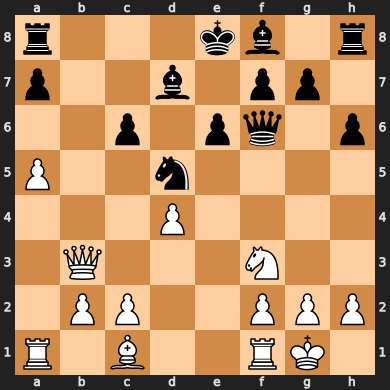

In [16]:
def check_model_prediction(model: torch.nn.Module,
                           random_fen: str,
                           fen_class: int,
                           device=device):
    """Takes the given fen to see the board, predicted score and actual score"""

    numpy_fen = fen_to_vector_with_state(random_fen)
    torch_fen = torch.tensor(numpy_fen, dtype=torch.float32).unsqueeze(0).to(device)
    pred = torch.argmax(model(torch_fen), dim=-1)
    print("Model Prediction: ", pred.item())
    print("Stockfish Evaluation: ", fen_class)

# Remember to update fen_class manually
random_fen = "r3kb1r/p2b1pp1/2p1pq1p/P2n4/3P4/1Q3N2/1PP2PPP/R1B2RK1 b kq - 2 14"
check_model_prediction(model=model,
                       random_fen=random_fen,
                       fen_class=5, # remember to manually set 
                       device=device)

board = chess.Board(random_fen)
board

In [17]:
from sklearn.metrics import classification_report

all_preds = []
all_labels = []

model.eval()
with torch.inference_mode():
    for X, y in val_dataloader:
        X, y = X.to(device), y.to(device)
        preds = model(X).argmax(dim=1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(y.cpu().numpy())

print(classification_report(all_labels, all_preds))


              precision    recall  f1-score   support

           0       0.85      0.72      0.78      5000
           1       0.69      0.75      0.72      7016
           2       0.76      0.66      0.71     14276
           3       0.89      0.94      0.91     57569
           4       0.75      0.65      0.69      7776
           5       0.69      0.72      0.70      4864
           6       0.82      0.72      0.77      3499

    accuracy                           0.83    100000
   macro avg       0.78      0.74      0.76    100000
weighted avg       0.83      0.83      0.83    100000



In [18]:
import json
import time

def save_config_metadata(experiment_name: str, 
                         model: torch.nn.Module, 
                         hyperparams: dict, 
                         dataset_paths: dict,
                         save_dir: str = "experiments/logs"):
    """
    Saves all 'static' setup details: Model architecture, parameter counts, 
    datasets used, and hyperparameters.
    """
    Path(save_dir).mkdir(parents=True, exist_ok=True)
    
    # Model Metadata
    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    
    config_data = {
        "experiment_name": experiment_name,
        "timestamp": time.strftime("%Y-%m-%d %H:%M:%S"),
        "model_architecture": {
            "class_name": model.__class__.__name__,
            "total_parameters": total_params,
            "trainable_parameters": trainable_params,
            "input_dim": hyperparams.get("input_shape", "unknown"),
            "output_dim": hyperparams.get("output_shape", "unknown"),
            "structure_summary": str(model)
        },
        "datasets": dataset_paths,
        "hyperparameters": hyperparams,
        "device": torch.cuda.get_device_name() if torch.cuda.is_available() else "cpu"
    }

    file_path = f"{save_dir}/{experiment_name}_config.json"
    with open(file_path, "w") as f:
        json.dump(config_data, f, indent=4)
    
    print(f"[Config] Saved metadata to {file_path}")


In [19]:
def save_training_logs(experiment_name: str, 
                       results_dict: dict, 
                       save_dir: str = "experiments/logs"):
    """
    Saves the epoch-by-epoch learning curves (Loss/Acc) to CSV.
    Expects results_dict to be the output from your run_experiment function.
    """
    Path(save_dir).mkdir(parents=True, exist_ok=True)
    
    df = pd.DataFrame(results_dict)
    
    if "epoch" not in df.columns:
        df["epoch"] = range(1, len(df) + 1)
        
    file_path = f"{save_dir}/{experiment_name}_learning_curves.csv"
    df.to_csv(file_path, index=False)
    
    print(f"[Logs] Saved training history to {file_path}")

In [20]:
import numpy as np
from pathlib import Path
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from typing import List, Dict, Tuple

def calculate_ordinal_metrics(preds: np.ndarray,
                              labels: np.ndarray) -> Dict[str, float]:
    """
    Calculates metrics specific to ordinal classification (where Class 0 is close to Class 1).
    """
    abs_diffs = np.abs(preds - labels)
    
    metrics = {
        "mae": float(np.mean(abs_diffs)),
        "off_by_one_accuracy": float(np.mean(abs_diffs <= 1)),
        "off_by_two_accuracy": float(np.mean(abs_diffs <= 2))
    }
    return metrics

def categorize_failures(preds: np.ndarray, 
                        labels: np.ndarray) -> Dict[int, List[int]]:
    """
    Categorizes errors by magnitude.
    Returns a dict where keys are the error magnitude (3, 4, 5, 6) and values are lists of dataset indices.
    """
    abs_diffs = np.abs(preds - labels)
    failure_dict = {}
    
    # We care about errors >= 3 (e.g. Predicting 'Equal' when 'Black Winning')
    # Max error is 6 (Predicting 'White Winning' when 'Black Winning')
    for magnitude in range(3, 7):
        indices = np.where(abs_diffs == magnitude)[0].tolist()
        if indices:
            failure_dict[magnitude] = indices
            
    return failure_dict

def run_inference(model: torch.nn.Module, 
                  dataloader: torch.utils.data.DataLoader, 
                  device: str) -> Tuple[np.ndarray, np.ndarray, float]:
    """
    Runs inference and tracks latency. Returns predictions, true labels, and avg latency per sample (ms).
    """
    model.eval()
    all_preds = []
    all_labels = []
    
    start_time = time.time()
    
    with torch.inference_mode():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            preds = model(X).argmax(dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(y.cpu().numpy())
            
    total_time = time.time() - start_time
    num_samples = len(all_labels)
    avg_latency_ms = (total_time / num_samples) * 1000
    
    return np.array(all_preds), np.array(all_labels), avg_latency_ms

def save_test_results(experiment_name: str, 
                      model: torch.nn.Module, 
                      test_dataloader: torch.utils.data.DataLoader, 
                      device: str,
                      save_dir: str = "experiments/results"):
    """
    Orchestrates the testing process and saves all research-grade metrics.
    """
    Path(save_dir).mkdir(parents=True, exist_ok=True)
        
    preds, labels, latency_ms = run_inference(model, test_dataloader, device)

    acc = accuracy_score(labels, preds)
    class_report = classification_report(labels, preds, output_dict=True)
    conf_matrix = confusion_matrix(labels, preds)
    ordinal_metrics = calculate_ordinal_metrics(preds, labels)
    failure_indices = categorize_failures(preds, labels)
    
    final_metrics = {
        "experiment_name": experiment_name,
        "global_accuracy": acc,
        "inference_latency_ms": latency_ms,
        "ordinal_metrics": ordinal_metrics,
        "catastrophic_failure_counts": {k: len(v) for k, v in failure_indices.items()},
        "classification_report": class_report
    }

    json_path = f"{save_dir}/{experiment_name}_metrics.json"
    with open(json_path, "w") as f:
        json.dump(final_metrics, f, indent=4)
        
    npy_path = f"{save_dir}/{experiment_name}_confusion_matrix.npy"
    np.save(npy_path, conf_matrix)
    
    # Failure Indices JSON (for later visual analysis of specific FENs)
    failures_path = f"{save_dir}/{experiment_name}_failure_indices.json"
    with open(failures_path, "w") as f:
        json.dump(failure_indices, f)
    
    print("-" * 60)
    print(f"[Results] Accuracy:        {acc*100:.2f}%")
    print(f"[Results] Off-by-1 Acc:    {ordinal_metrics['off_by_one_accuracy']*100:.2f}%")
    print(f"[Results] MAE:             {ordinal_metrics['mae']:.4f}")
    print(f"[Results] Latency:         {latency_ms:.4f} ms/sample")
    print("[Results] Catastrophic Failures (Count):")
    for k in sorted(failure_indices.keys()):
        print(f"   - Off by {k}: {len(failure_indices[k])} samples")
    print(f"[Results] Saved all metrics to {save_dir}")
    print("-" * 60)

In [21]:
RUN_ID = "run_2025_12_28_deepchess_baseline_v2"

hyperparams = {
    "epochs": NUM_EPOCHS,
    "batch_size": BATCH_SIZE,
    "learning_rate": 0.001,
    "optimizer": "Adam",
    "input_shape": 774,
    "output_shape": 7,
    "weight_decay": 0.0001
}

dataset_paths = {
    "train": "./dataset_processed/chess_state_bitboard_train.npz",
    "val":   "./dataset_processed/chess_state_bitboard_val.npz",
    "test":  "./dataset_processed/chess_state_bitboard_test.npz"
}

save_config_metadata(experiment_name=RUN_ID,
                     model=model,
                     hyperparams=hyperparams,
                     dataset_paths=dataset_paths)

# Save Training Logs (Using the 'result' variable from run_experiment)
save_training_logs(experiment_name=RUN_ID, 
                   results_dict=result)

save_test_results(experiment_name=RUN_ID,
                  model=model,
                  test_dataloader=test_dataloader,
                  device=device)

[Config] Saved metadata to experiments/logs/run_2025_12_28_deepchess_baseline_v2_config.json
[Logs] Saved training history to experiments/logs/run_2025_12_28_deepchess_baseline_v2_learning_curves.csv
------------------------------------------------------------
[Results] Accuracy:        83.45%
[Results] Off-by-1 Acc:    97.60%
[Results] MAE:             0.2040
[Results] Latency:         0.0076 ms/sample
[Results] Catastrophic Failures (Count):
   - Off by 3: 776 samples
   - Off by 4: 119 samples
   - Off by 5: 57 samples
   - Off by 6: 66 samples
[Results] Saved all metrics to experiments/results
------------------------------------------------------------


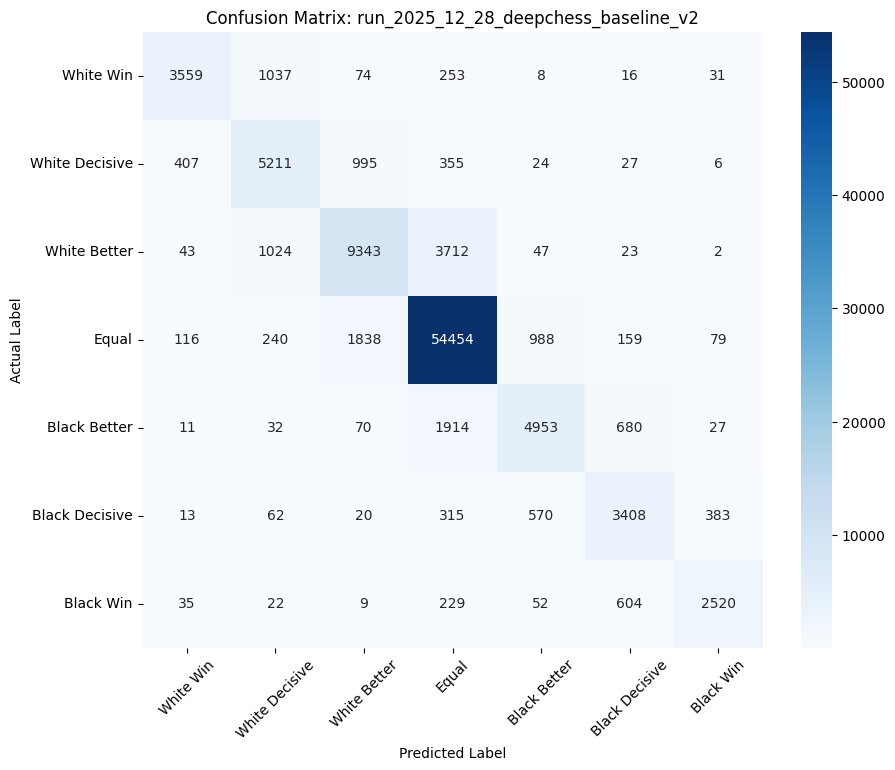

In [22]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

def plot_confusion_matrix(experiment_name: str, save_dir: str = "experiments/results"):
    matrix_path = f"{save_dir}/{experiment_name}_confusion_matrix.npy"
    try:
        cm = np.load(matrix_path)
    except FileNotFoundError:
        print(f"Could not find matrix at {matrix_path}")
        return

    class_names = [
        "White Win", "White Decisive", "White Better", "Equal", 
        "Black Better", "Black Decisive", "Black Win"
    ]

    plt.figure(figsize=(10, 8))

    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=class_names, 
                yticklabels=class_names)
    
    plt.title(f"Confusion Matrix: {experiment_name}")
    plt.ylabel('Actual Label')
    plt.xlabel('Predicted Label')
    plt.xticks(rotation=45)
    plt.show()

plot_confusion_matrix(RUN_ID)